In [ ]:
# Mount google drive
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import glob
import cv2 # importing OpenCV library
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras import datasets, layers, optimizers, utils, losses, Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout, Flatten, experimental, Lambda
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import gc
import os
import sys
import csv
from pathlib import Path
import shutil

%matplotlib inline

**Upload images**

In [ ]:
#Unzip pictures from google drive into colab VM to speed up the processing
#!unzip "/content/drive/MyDrive/COMP1804_CW/COMP1804_PICS.zip" -d "/content"

In [ ]:
## Load the annotations file and create
file_name = '/content/drive/MyDrive/annotations.csv'
with open(file_name) as fil:
 next(fil) 
 content = fil.readlines()

input_labels = []
input_images = []

for elem in content:
  line = elem.split(',')
  input_images.append(line[0])
  input_labels.append([int(line[1]),int(line[2]),int(line[3]),int(line[4]),int(line[5]),int(line[6])])


In [ ]:
#Provide the path where the pictures are available
location = '/content/COMP1804_PICS/'

#Use face cascade to crop the face out of the images and save into the required resoltuion
cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml" 
face_cascade = cv2.CascadeClassifier(cascade_path)

crop_path = "/content/crop_images/"
if os.path.exists(crop_path):
  shutil.rmtree(crop_path)
  Path(crop_path).mkdir()
else:
  Path(crop_path).mkdir()

idx = 0
crop_images_input = [] # list to collect the cropped images, it may contain more than one result per raw image providede
labels_input = [] # list of labels obtained from the annotation tool

for img in input_images:

  img = cv2.imread(location + img)
  faces = face_cascade.detectMultiScale(img, 1.1, 3, minSize=(100,100))
  
  if (faces is None):
    # in case a face is not detected just increase the index
    idx += 1
  else:
    i = 0 #number of faces detected in the same raw image
    #height, width = img.shape[:2]

    for (x, y, w, h) in faces:
      r = max(w, h) / 2
      if y <= 80:          # to avoid out of bonds error when shifting the crop upward
        centerx = x + w / 2
        centery = y-y + h / 2
        nx = int(centerx - r)
        ny = int(centery - r + y)
        nr = int(r * 2)
      else:
        centerx = x + w / 2
        centery = y-80 + h / 2 # shifting the crop upward to obtain the hair
        nx = int(centerx - r)
        ny = int(centery - r)
        nr = int(r * 2)

      faceimg = img[ny:ny+nr, nx:nx+nr]
      lastimg = cv2.resize(faceimg, (224, 224))
      # Saving the file of generated picture for further analysis and checks
      # Format image_0000_
      cv2.imwrite(crop_path + "image_" + str(idx).zfill(4) + "_" + str(i).zfill(2) + ".jpg" , lastimg)
      lastimg_rgb = cv2.cvtColor(lastimg, cv2.COLOR_BGR2RGB)
      crop_images_input.append(lastimg_rgb)
      labels_input.append(input_labels[idx])
      i += 1
    
    idx += 1

In [ ]:
len(crop_images_input)

2128

**Removal of non human face as per annotation tool**

In [ ]:
# Create label numpy array
labels = np.array(labels_input)

# Create crop images numpy array
crop_images = np.array(crop_images_input)

# Identify the records where there is no human face
not_human = pd.DataFrame(labels[:,5])
lst_not_human = not_human.index[not_human[0] == 1].tolist()

# Remove non human faces from crop images and labels
images_clean = np.delete(crop_images, lst_not_human, axis=0)
labels_clean = np.delete(labels, lst_not_human, axis=0)


In [ ]:
# Create separate labels for each category
wrinkles_lbl = labels_clean[:,0]
freakles_lbl = labels_clean[:,1]
glasses_lbl = labels_clean[:,2]
hair_color_lbl = labels_clean[:,3]
hair_top_lbl = labels_clean[:,4]

**EDA**

Distribution of wrinkles: No Wrinkles 1391, Wrinkles 539
Distribution of freakles: No Freakles 1924, Freakles 6
Distribution of glasses: No Glasses 1700, Glasses 207 Sunglasses 23
Distribution of hair color: Brown 597, Black 498, Gray 280, Blond 322, Red 68, White 60, Mixed 20, Other 10, Not Visible 75
Distribution of hair top: Bald/Shaved 30, Thin hair 164, Thick hair 1532, Not Visible 204


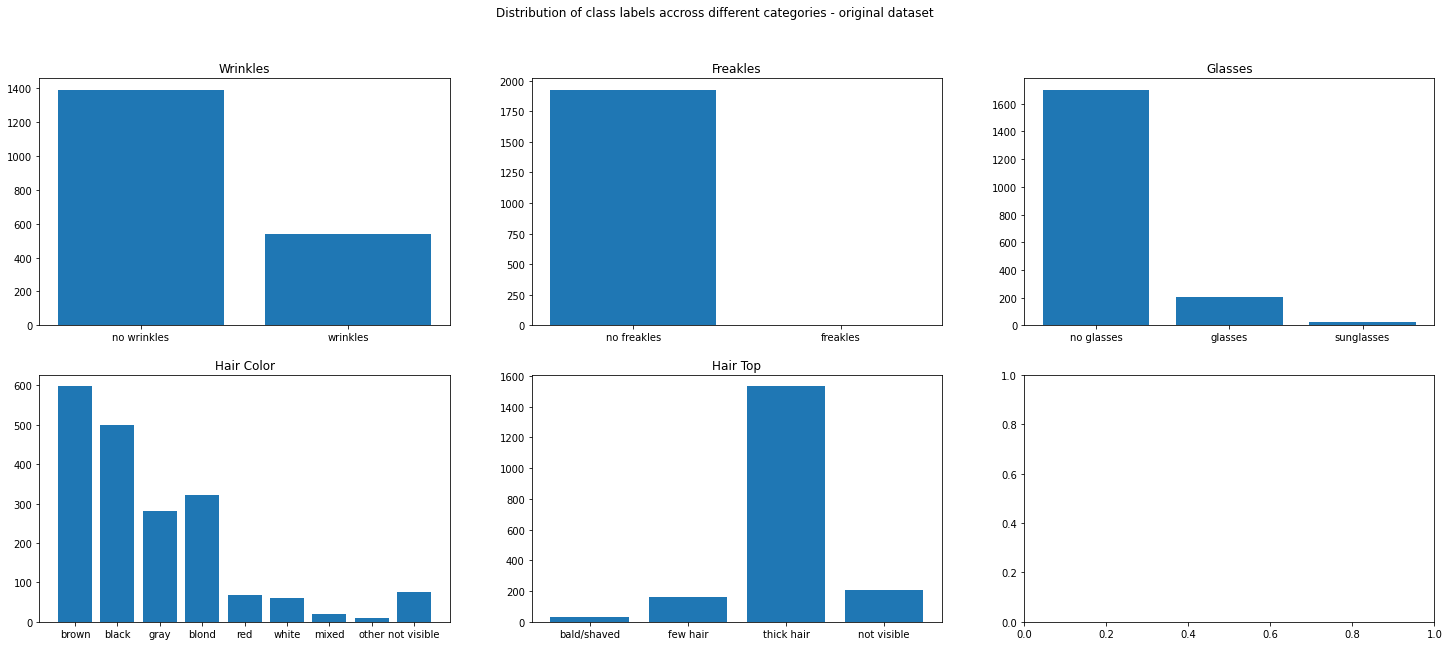

In [ ]:
# Check distribution for each class accross categories

wrinkles_x = ["no wrinkles", "wrinkles"]
wrinkles_y = np.bincount(wrinkles_lbl)

freakles_x = ["no freakles", "freakles"]
freakles_y = np.bincount(freakles_lbl)

glasses_x = ["no glasses", "glasses", "sunglasses"]
glasses_y = np.bincount(glasses_lbl)

hair_color_x = ["brown", "black", "gray", "blond", "red", "white", "mixed", "other", "not visible"]
hair_color_y = np.bincount(hair_color_lbl)

hair_top_x = ["bald/shaved", "few hair", "thick hair", "not visible"]
hair_top_y = np.bincount(hair_top_lbl)

fig, axs = plt.subplots(2, 3,figsize=(25,10))
fig.suptitle('Distribution of class labels accross different categories - original dataset')
axs[0, 0].bar(wrinkles_x, wrinkles_y)
axs[0, 0].set_title("Wrinkles")
axs[0, 1].bar(freakles_x, freakles_y)
axs[0, 1].set_title("Freakles")
axs[0, 2].bar(glasses_x, glasses_y)
axs[0, 2].set_title("Glasses")
axs[1, 0].bar(hair_color_x, hair_color_y)
axs[1, 0].set_title("Hair Color")
axs[1, 1].bar(hair_top_x, hair_top_y)
axs[1, 1].set_title("Hair Top")

print('Distribution of wrinkles: No Wrinkles ' + str(wrinkles_y[0]) +', Wrinkles ' + str(wrinkles_y[1]))
print('Distribution of freakles: No Freakles ' + str(freakles_y[0]) +', Freakles ' + str(freakles_y[1]))
print('Distribution of glasses: No Glasses ' + str(glasses_y[0]) +', Glasses ' + str(glasses_y[1])+' Sunglasses ' + str(glasses_y[2]))
print('Distribution of hair color: Brown ' + str(hair_color_y[0]) +', Black ' + str(hair_color_y[1])+', Gray ' + str(hair_color_y[2])
+', Blond ' + str(hair_color_y[3])+', Red ' + str(hair_color_y[4])
+', White ' + str(hair_color_y[5])+', Mixed ' + str(hair_color_y[6])
+', Other ' + str(hair_color_y[7])+', Not Visible ' + str(hair_color_y[8]))
print('Distribution of hair top: Bald/Shaved ' + str(hair_top_y[0]) +', Thin hair ' + str(hair_top_y[1])+', Thick hair ' + str(hair_top_y[2])
+', Not Visible ' + str(hair_top_y[3]))

In [ ]:
df_labels = pd.DataFrame(labels_clean, columns=["wr","fr","gl","hc","ht","hm"])

In [ ]:
category = ["wr","fr","gl","hc","ht","hm"]
aug_folder = "/content/images_train_aug/"

for cat in range(len(category)):
  aug_folder = "/content/images_train_aug/" + category[cat]
  if os.path.exists(aug_folder):
    shutil.rmtree(aug_folder)
    Path(aug_folder).mkdir(parents=True)
  else:
    Path(aug_folder).mkdir(parents=True) 

In [ ]:
def data_aug(images_array, labels_df, class_int ,category, rng):
  
  aug_path = "/content/images_train_aug/" + category + "/"



  datagen = ImageDataGenerator(width_shift_range=[-0.15,0.15],horizontal_flip=True,
                             rotation_range=25,brightness_range=[0.7,1.3])
  
  list_imgs = labels_df.index[labels_df[category] == class_int].tolist()
  img_include = images_array[list_imgs]
  # prepare iterator
  it = datagen.flow(img_include,batch_size=32, save_to_dir= aug_path, save_format = 'jpeg', save_prefix = category + '_' +str(class_int) )
  #rng = 27
# generate samples 
  for i in range(rng):
    batch = it.next()
    image = batch[0].astype('uint8')

In [ ]:
def data_aug_input(path):
  aug_pics = glob.glob(path)
  aug_pics.sort()
  labels_aug=[]
  images_aug=[]
  for aug_pic in aug_pics:
    idx_org_pic = str.split(os.path.basename(os.path.normpath(aug_pic)),'_')
    pre_lbl_aug = []
    lbl_value = idx_org_pic[1]
  #for elem in range(len(idx)):
  #  pre_lbl_aug.append(int(idx[elem]))
    labels_aug.append(int(lbl_value))
    pic = cv2.imread(aug_pic)
    pic_rgb = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
    images_aug.append(pic_rgb)
  
  return images_aug, labels_aug



**Wrinkles augmentation**

In [ ]:
data_aug(images_clean, df_labels, 1, "wr", 27 )

In [ ]:
images_aug_wr, labels_aug_wr = data_aug_input('/content/images_train_aug/wr/*')

In [ ]:
labels_train_wr = np.concatenate((labels_clean[:,0], labels_aug_wr), axis=0)

**Freakles augmentation**

In [ ]:
data_aug(images_clean, df_labels, 1, "fr", 320 )

In [ ]:
images_aug_fr, labels_aug_fr = data_aug_input('/content/images_train_aug/fr/*')

**Glasses augmentation**

In [ ]:
data_aug(images_clean, df_labels, 1, "gl", 47 )
data_aug(images_clean, df_labels, 2, "gl", 73 )

In [ ]:
images_aug_gl, labels_aug_gl = data_aug_input('/content/images_train_aug/gl/*')

**Hair color augmentation**

In [ ]:
data_aug(images_clean, df_labels, 1, "hc", 3 )
data_aug(images_clean, df_labels, 2, "hc", 10 )
data_aug(images_clean, df_labels, 3, "hc", 9 )
data_aug(images_clean, df_labels, 4, "hc", 19 )
data_aug(images_clean, df_labels, 5, "hc", 17 )
data_aug(images_clean, df_labels, 6, "hc", 29 )
data_aug(images_clean, df_labels, 7, "hc", 59 )
data_aug(images_clean, df_labels, 8, "hc", 19 )


In [ ]:
images_aug_hc, labels_aug_hc = data_aug_input('/content/images_train_aug/hc/*')

In [ ]:
data_aug(images_clean, df_labels, 0, "ht", 50 )
data_aug(images_clean, df_labels, 1, "ht", 44 )
data_aug(images_clean, df_labels, 3, "ht", 42 )

In [ ]:
images_aug_ht, labels_aug_ht = data_aug_input('/content/images_train_aug/ht/*')

**Create different datasets for training and respective labels**

In [ ]:
# Creating label files for each category
labels_wr_aug = np.concatenate((labels_clean[:,0], np.array(labels_aug_wr)), axis=0)
labels_fr_aug = np.concatenate((labels_clean[:,1], np.array(labels_aug_fr)), axis=0)
labels_gl_aug = np.concatenate((labels_clean[:,2], np.array(labels_aug_gl)), axis=0)
labels_hc_aug = np.concatenate((labels_clean[:,3], np.array(labels_aug_hc)), axis=0)
labels_ht_aug = np.concatenate((labels_clean[:,4], np.array(labels_aug_ht)), axis=0)

In [ ]:
# Creating training image files for each category
images_wr_aug = np.concatenate((images_clean, np.array(images_aug_wr)),axis=0)
images_fr_aug = np.concatenate((images_clean, np.array(images_aug_fr)),axis=0)
images_gl_aug = np.concatenate((images_clean, np.array(images_aug_gl)),axis=0)
images_hc_aug = np.concatenate((images_clean, np.array(images_aug_hc)),axis=0)
images_ht_aug = np.concatenate((images_clean, np.array(images_aug_ht)),axis=0)

In [ ]:
# Checking consistency accross labels and images rows
print(labels_wr_aug.shape)
print(images_wr_aug.shape)
print(labels_fr_aug.shape)
print(images_fr_aug.shape)
print(labels_gl_aug.shape)
print(images_gl_aug.shape)
print(labels_hc_aug.shape)
print(images_hc_aug.shape)
print(labels_ht_aug.shape)
print(images_ht_aug.shape)

(2789,)
(2789, 224, 224, 3)
(3816,)
(3816, 224, 224, 3)
(5005,)
(5005, 224, 224, 3)
(5227,)
(5227, 224, 224, 3)
(5862,)
(5862, 224, 224, 3)


Distribution of wrinkles: No Wrinkles 1391, Wrinkles 1398
Distribution of freakles: No Freakles 1924, Freakles 1892
Distribution of glasses: No Glasses 1700, Glasses 1609 Sunglasses 1696
Distribution of hair color: Brown 597, Black 594, Gray 592, Blond 610, Red 508, White 572, Mixed 599, Other 598, Not Visible 557
Distribution of hair top: Bald/Shaved 1526, Thin hair 1376, Thick hair 1532, Not Visible 1428


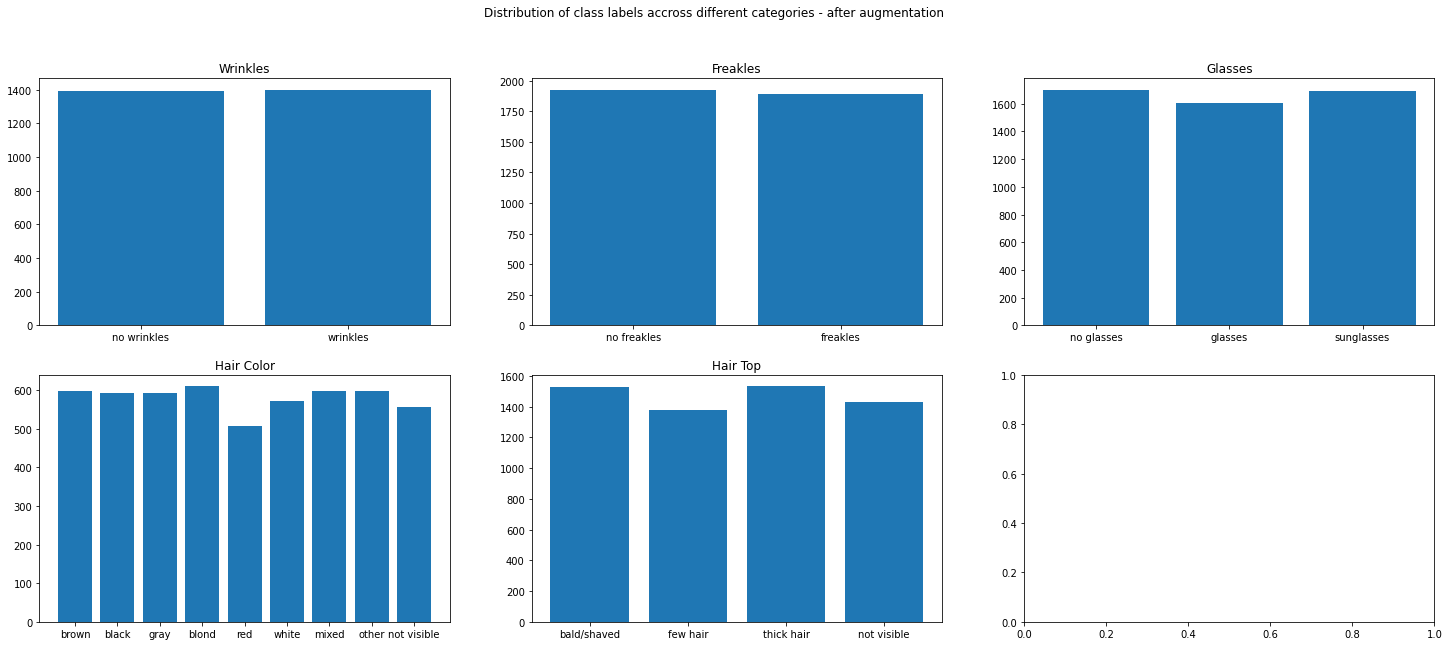

In [ ]:

wrinkles_x = ["no wrinkles", "wrinkles"]
wrinkles_y = np.bincount(labels_wr_aug)

freakles_x = ["no freakles", "freakles"]
freakles_y = np.bincount(labels_fr_aug)

glasses_x = ["no glasses", "glasses", "sunglasses"]
glasses_y = np.bincount(labels_gl_aug)

hair_color_x = ["brown", "black", "gray", "blond", "red", "white", "mixed", "other", "not visible"]
hair_color_y = np.bincount(labels_hc_aug)

hair_top_x = ["bald/shaved", "few hair", "thick hair", "not visible",]
hair_top_y = np.bincount(labels_ht_aug)

fig, axs = plt.subplots(2, 3,figsize=(25,10))
fig.suptitle('Distribution of class labels accross different categories - after augmentation')
axs[0, 0].bar(wrinkles_x, wrinkles_y)
axs[0, 0].set_title("Wrinkles")
axs[0, 1].bar(freakles_x, freakles_y)
axs[0, 1].set_title("Freakles")
axs[0, 2].bar(glasses_x, glasses_y)
axs[0, 2].set_title("Glasses")
axs[1, 0].bar(hair_color_x, hair_color_y)
axs[1, 0].set_title("Hair Color")
axs[1, 1].bar(hair_top_x, hair_top_y)
axs[1, 1].set_title("Hair Top")

print('Distribution of wrinkles: No Wrinkles ' + str(wrinkles_y[0]) +', Wrinkles ' + str(wrinkles_y[1]))
print('Distribution of freakles: No Freakles ' + str(freakles_y[0]) +', Freakles ' + str(freakles_y[1]))
print('Distribution of glasses: No Glasses ' + str(glasses_y[0]) +', Glasses ' + str(glasses_y[1])+' Sunglasses ' + str(glasses_y[2]))
print('Distribution of hair color: Brown ' + str(hair_color_y[0]) +', Black ' + str(hair_color_y[1])+', Gray ' + str(hair_color_y[2])
+', Blond ' + str(hair_color_y[3])+', Red ' + str(hair_color_y[4])
+', White ' + str(hair_color_y[5])+', Mixed ' + str(hair_color_y[6])
+', Other ' + str(hair_color_y[7])+', Not Visible ' + str(hair_color_y[8]))
print('Distribution of hair top: Bald/Shaved ' + str(hair_top_y[0]) +', Thin hair ' + str(hair_top_y[1])+', Thick hair ' + str(hair_top_y[2])
+', Not Visible ' + str(hair_top_y[3]))

**Split between training and test datasets**

In [ ]:
X_train_wr, X_test_wr, y_train_wr, y_test_wr = train_test_split(images_wr_aug, labels_wr_aug, test_size=0.2, random_state=42)

X_train_fr, X_test_fr, y_train_fr, y_test_fr = train_test_split(images_fr_aug, labels_fr_aug, test_size=0.2, random_state=42)

X_train_gl, X_test_gl, y_train_gl, y_test_gl = train_test_split(images_gl_aug, labels_gl_aug, test_size=0.2, random_state=42)

X_train_hc, X_test_hc, y_train_hc, y_test_hc = train_test_split(images_hc_aug, labels_hc_aug, test_size=0.2, random_state=42)

X_train_ht, X_test_ht, y_train_ht, y_test_ht = train_test_split(images_ht_aug, labels_ht_aug, test_size=0.2, random_state=42)

In [ ]:
image_input = Input(shape=(224,224,3), name='image')
preproc_img = Lambda(lambda x: x / 255)(image_input) # normalising
data_augmentation = Sequential(
    [   #preprocessing.Resizing(height=32, width=32, interpolation="bilinear"),
        experimental.preprocessing.RandomFlip("horizontal"),
        experimental.preprocessing.RandomRotation(0.1),
        experimental.preprocessing.RandomZoom(0.1),
    ]
)(preproc_img)


# load model without classifier layers
model = VGG16(include_top=False, weights="imagenet", input_tensor=data_augmentation) 
    
### If we want to freeze these pretrained weights:
for layer in model.layers:
  layer.trainable = False     # mark loaded layers as not trainable

# add new classifier layers
flat1 = layers.Flatten()(model.layers[-1].output)
fc1 = layers.Dense(256, activation='relu')(flat1)
fc2 = layers.Dense(256, activation='relu')(fc1)
wrinkles_pred = Dense(1, activation='sigmoid',name='wrinkles')(fc2)
#freakles_pred = Dense(1, activation='sigmoid',name='freakles')(fc2)
#glasses_pred = Dense(3, activation='softmax',name='glasses')(fc2)
#hair_color_pred = Dense(9, activation='softmax',name='hair_color')(fc2)
#hair_top_pred = Dense(4, activation='softmax',name='hair_top')(fc2)


model_wr = Model(
    inputs = model.inputs,
    #outputs = [wrinkles_pred, freakles_pred, glasses_pred, hair_color_pred, hair_top_pred])
    outputs = wrinkles_pred)
model_wr.summary()

In [ ]:


# load model without classifier layers
#model = VGG16(include_top=False, weights="imagenet", input_tensor=preproc_img) 
model = VGG16(include_top=False, weights="imagenet", input_tensor=data_augmentation) 

### If we want to freeze these pretrained weights:
for layer in model.layers:
  layer.trainable = False     # mark loaded layers as not trainable

# add new classifier layers
flat1 = layers.Flatten()(model.layers[-1].output)
fc1 = layers.Dense(256, activation='relu')(flat1)
fc2 = layers.Dense(256, activation='relu')(fc1)
#wrinkles_pred = Dense(1, activation='sigmoid',name='wrinkles')(fc2)
freakles_pred = Dense(1, activation='sigmoid',name='freakles')(fc2)
#glasses_pred = Dense(3, activation='softmax',name='glasses')(fc2)
#hair_color_pred = Dense(9, activation='softmax',name='hair_color')(fc2)
#hair_top_pred = Dense(4, activation='softmax',name='hair_top')(fc2)


model_fr = Model(
    inputs = model.inputs,
    #outputs = [wrinkles_pred, freakles_pred, glasses_pred, hair_color_pred, hair_top_pred])
    outputs = freakles_pred)
#model_fr.summary()

In [ ]:


# load model without classifier layers
model = VGG16(include_top=False, weights="imagenet", input_tensor=data_augmentation) 
    
### If we want to freeze these pretrained weights:
for layer in model.layers:
  layer.trainable = False     # mark loaded layers as not trainable

# add new classifier layers
flat1 = layers.Flatten()(model.layers[-1].output)
fc1 = layers.Dense(256, activation='relu')(flat1)
fc2 = layers.Dense(256, activation='relu')(fc1)
#wrinkles_pred = Dense(1, activation='sigmoid',name='wrinkles')(fc2)
#freakles_pred = Dense(1, activation='sigmoid',name='freakles')(fc2)
glasses_pred = Dense(3, activation='softmax',name='glasses')(fc2)
#hair_color_pred = Dense(9, activation='softmax',name='hair_color')(fc2)
#hair_top_pred = Dense(4, activation='softmax',name='hair_top')(fc2)


model_gl = Model(
    inputs = model.inputs,
    #outputs = [wrinkles_pred, freakles_pred, glasses_pred, hair_color_pred, hair_top_pred])
    outputs = glasses_pred)
#model_gl.summary()

In [ ]:


# load model without classifier layers
model = VGG16(include_top=False, weights="imagenet", input_tensor=data_augmentation) 
    
### If we want to freeze these pretrained weights:
for layer in model.layers:
  layer.trainable = False     # mark loaded layers as not trainable

# add new classifier layers
flat1 = layers.Flatten()(model.layers[-1].output)
fc1 = layers.Dense(256, activation='relu')(flat1)
fc2 = layers.Dense(256, activation='relu')(fc1)
#wrinkles_pred = Dense(1, activation='sigmoid',name='wrinkles')(fc2)
#freakles_pred = Dense(1, activation='sigmoid',name='freakles')(fc2)
#glasses_pred = Dense(3, activation='softmax',name='glasses')(fc2)
hair_color_pred = Dense(9, activation='softmax',name='hair_color')(fc2)
#hair_top_pred = Dense(4, activation='softmax',name='hair_top')(fc2)

model_hc = Model(
    inputs = model.inputs,
    #outputs = [wrinkles_pred, freakles_pred, glasses_pred, hair_color_pred, hair_top_pred])
    outputs = hair_color_pred)
#model_hc.summary()

In [ ]:


# load model without classifier layers
model = VGG16(include_top=False, weights="imagenet", input_tensor=data_augmentation) 
    
### If we want to freeze these pretrained weights:
for layer in model.layers:
  layer.trainable = False     # mark loaded layers as not trainable

# add new classifier layers
flat1 = layers.Flatten()(model.layers[-1].output)
fc1 = layers.Dense(256, activation='relu')(flat1)
fc2 = layers.Dense(256, activation='relu')(fc1)
#wrinkles_pred = Dense(1, activation='sigmoid',name='wrinkles')(fc2)
#freakles_pred = Dense(1, activation='sigmoid',name='freakles')(fc2)
#glasses_pred = Dense(3, activation='softmax',name='glasses')(fc2)
#hair_color_pred = Dense(9, activation='softmax',name='hair_color')(fc2)
hair_top_pred = Dense(4, activation='softmax',name='hair_top')(fc2)


model_ht = Model(
    inputs = model.inputs,
    #outputs = [wrinkles_pred, freakles_pred, glasses_pred, hair_color_pred, hair_top_pred])
    outputs = hair_top_pred)
#model_ht.summary()

In [ ]:
model_wr.compile(
    optimizer= Adam(learning_rate=0.0001), #SGD(lr=0.0001),
    loss={
        "wrinkles": losses.BinaryCrossentropy(),
        #"freakles": losses.BinaryCrossentropy(),
        #"glasses": losses.SparseCategoricalCrossentropy(),
        #"hair_color": losses.SparseCategoricalCrossentropy(),
        #"hair_top": losses.SparseCategoricalCrossentropy(),
        },
    loss_weights=[0.3], #, 0.2, 0.2, 1.2, 0.2],
    metrics=['accuracy'])

In [ ]:
model_fr.compile(
    optimizer= Adam(learning_rate=0.0001), #SGD(lr=0.0001),
    loss={
        #"wrinkles": losses.BinaryCrossentropy(),
        "freakles": losses.BinaryCrossentropy(),
        #"glasses": losses.SparseCategoricalCrossentropy(),
        #"hair_color": losses.SparseCategoricalCrossentropy(),
        #"hair_top": losses.SparseCategoricalCrossentropy(),
        },
    loss_weights=[0.3], #, 0.2, 0.2, 1.2, 0.2],
    metrics=['accuracy'])

In [ ]:
model_gl.compile(
    optimizer= Adam(learning_rate=0.0001), #SGD(lr=0.0001),
    loss={
        #"wrinkles": losses.BinaryCrossentropy(),
        #"freakles": losses.BinaryCrossentropy(),
        "glasses": losses.SparseCategoricalCrossentropy(),
        #"hair_color": losses.SparseCategoricalCrossentropy(),
        #"hair_top": losses.SparseCategoricalCrossentropy(),
        },
    loss_weights=[0.3], #, 0.2, 0.2, 1.2, 0.2],
    metrics=['accuracy'])

In [ ]:
model_hc.compile(
    optimizer= Adam(learning_rate=0.0001), #SGD(lr=0.0001),
    loss={
        #"wrinkles": losses.BinaryCrossentropy(),
        #"freakles": losses.BinaryCrossentropy(),
        #"glasses": losses.SparseCategoricalCrossentropy(),
        "hair_color": losses.SparseCategoricalCrossentropy(),
        #"hair_top": losses.SparseCategoricalCrossentropy(),
        },
    loss_weights=[0.3], #, 0.2, 0.2, 1.2, 0.2],
    metrics=['accuracy'])

In [ ]:
model_ht.compile(
    optimizer= Adam(learning_rate=0.0001), #SGD(lr=0.0001),
    loss={
        #"wrinkles": losses.BinaryCrossentropy(),
        #"freakles": losses.BinaryCrossentropy(),
        #"glasses": losses.SparseCategoricalCrossentropy(),
        #"hair_color": losses.SparseCategoricalCrossentropy(),
        "hair_top": losses.SparseCategoricalCrossentropy(),
        },
    loss_weights=[0.3], #, 0.2, 0.2, 1.2, 0.2],
    metrics=['accuracy'])

In [ ]:
history_wr = model_wr.fit(
    X_train_wr,
    {"wrinkles": y_train_wr},
     batch_size=32,epochs=20,
     validation_data=(X_test_wr,y_test_wr))
     #validation_split=0.2)

Epoch 1/20
70/70 [==============================] - 28s 136ms/step - loss: 0.1905 - accuracy: 0.6225 - val_loss: 0.1278 - val_accuracy: 0.8047
Epoch 2/20
70/70 [==============================] - 5s 78ms/step - loss: 0.1224 - accuracy: 0.8098 - val_loss: 0.1083 - val_accuracy: 0.8423
Epoch 3/20
70/70 [==============================] - 5s 78ms/step - loss: 0.1082 - accuracy: 0.8417 - val_loss: 0.1062 - val_accuracy: 0.8315
Epoch 4/20
70/70 [==============================] - 5s 78ms/step - loss: 0.0982 - accuracy: 0.8561 - val_loss: 0.1116 - val_accuracy: 0.8351
Epoch 5/20
70/70 [==============================] - 5s 78ms/step - loss: 0.0905 - accuracy: 0.8773 - val_loss: 0.1056 - val_accuracy: 0.8405
Epoch 6/20
70/70 [==============================] - 5s 78ms/step - loss: 0.0851 - accuracy: 0.8807 - val_loss: 0.1201 - val_accuracy: 0.7957
Epoch 7/20
70/70 [==============================] - 5s 78ms/step - loss: 0.0947 - accuracy: 0.8657 - val_loss: 0.1154 - val_accuracy: 0.8351
Epoch 8/20


In [ ]:
history_fr = model_fr.fit(
    X_train_fr,
    {"freakles": y_train_fr},
     batch_size=32,epochs=20,
     validation_data=(X_test_fr,y_test_fr))
     #validation_split=0.2)

Epoch 1/20
96/96 [==============================] - 12s 113ms/step - loss: 0.0953 - accuracy: 0.8583 - val_loss: 0.0031 - val_accuracy: 0.9961
Epoch 2/20
96/96 [==============================] - 7s 77ms/step - loss: 0.0040 - accuracy: 0.9981 - val_loss: 0.0029 - val_accuracy: 0.9974
Epoch 3/20
96/96 [==============================] - 7s 77ms/step - loss: 0.0026 - accuracy: 0.9977 - val_loss: 0.0015 - val_accuracy: 0.9974
Epoch 4/20
96/96 [==============================] - 7s 77ms/step - loss: 0.0010 - accuracy: 0.9996 - val_loss: 0.0017 - val_accuracy: 0.9974
Epoch 5/20
96/96 [==============================] - 7s 77ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 6.6707e-04 - val_accuracy: 0.9987
Epoch 6/20
96/96 [==============================] - 7s 77ms/step - loss: 0.0011 - accuracy: 0.9993 - val_loss: 3.8988e-04 - val_accuracy: 1.0000
Epoch 7/20
96/96 [==============================] - 7s 77ms/step - loss: 7.1257e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 0.9974

In [ ]:
history_gl = model_gl.fit(
    X_train_gl,
    {"glasses": y_train_gl},
     batch_size=32,epochs=20,
     validation_data=(X_test_gl,y_test_gl))
     #validation_split=0.2)

Epoch 1/20
125/125 [==============================] - 14s 108ms/step - loss: 0.2137 - accuracy: 0.6657 - val_loss: 0.0495 - val_accuracy: 0.9500
Epoch 2/20
125/125 [==============================] - 10s 77ms/step - loss: 0.0493 - accuracy: 0.9563 - val_loss: 0.0216 - val_accuracy: 0.9800
Epoch 3/20
125/125 [==============================] - 10s 77ms/step - loss: 0.0283 - accuracy: 0.9735 - val_loss: 0.0147 - val_accuracy: 0.9850
Epoch 4/20
125/125 [==============================] - 10s 77ms/step - loss: 0.0232 - accuracy: 0.9784 - val_loss: 0.0114 - val_accuracy: 0.9870
Epoch 5/20
125/125 [==============================] - 10s 77ms/step - loss: 0.0127 - accuracy: 0.9896 - val_loss: 0.0114 - val_accuracy: 0.9860
Epoch 6/20
125/125 [==============================] - 10s 77ms/step - loss: 0.0116 - accuracy: 0.9880 - val_loss: 0.0167 - val_accuracy: 0.9810
Epoch 7/20
125/125 [==============================] - 10s 77ms/step - loss: 0.0124 - accuracy: 0.9882 - val_loss: 0.0132 - val_accuracy

In [ ]:
history_hc = model_hc.fit(
    X_train_hc,
    {"hair_color": y_train_hc},
     batch_size=32,epochs=20,
     validation_data=(X_test_hc,y_test_hc))
     #validation_split=0.2)

Epoch 1/20
131/131 [==============================] - 15s 110ms/step - loss: 0.5918 - accuracy: 0.2751 - val_loss: 0.4010 - val_accuracy: 0.5277
Epoch 2/20
131/131 [==============================] - 10s 77ms/step - loss: 0.3907 - accuracy: 0.5385 - val_loss: 0.3543 - val_accuracy: 0.5975
Epoch 3/20
131/131 [==============================] - 10s 77ms/step - loss: 0.3263 - accuracy: 0.6238 - val_loss: 0.3114 - val_accuracy: 0.6291
Epoch 4/20
131/131 [==============================] - 10s 78ms/step - loss: 0.2757 - accuracy: 0.6786 - val_loss: 0.2816 - val_accuracy: 0.6577
Epoch 5/20
131/131 [==============================] - 10s 77ms/step - loss: 0.2510 - accuracy: 0.7127 - val_loss: 0.2705 - val_accuracy: 0.6883
Epoch 6/20
131/131 [==============================] - 10s 77ms/step - loss: 0.2347 - accuracy: 0.7314 - val_loss: 0.2733 - val_accuracy: 0.6769
Epoch 7/20
131/131 [==============================] - 10s 78ms/step - loss: 0.2189 - accuracy: 0.7483 - val_loss: 0.2623 - val_accuracy

In [ ]:
history_ht = model_ht.fit(
    X_train_ht,
    {"hair_top": y_train_ht},
     batch_size=32,epochs=20,
     validation_data=(X_test_ht,y_test_ht))
     #validation_split=0.2)

Epoch 1/20
147/147 [==============================] - 14s 89ms/step - loss: 0.3448 - accuracy: 0.4757 - val_loss: 0.1729 - val_accuracy: 0.8055
Epoch 2/20
147/147 [==============================] - 11s 77ms/step - loss: 0.1958 - accuracy: 0.7510 - val_loss: 0.1199 - val_accuracy: 0.8635
Epoch 3/20
147/147 [==============================] - 11s 77ms/step - loss: 0.1311 - accuracy: 0.8465 - val_loss: 0.0984 - val_accuracy: 0.8823
Epoch 4/20
147/147 [==============================] - 11s 77ms/step - loss: 0.1039 - accuracy: 0.8726 - val_loss: 0.0832 - val_accuracy: 0.9155
Epoch 5/20
147/147 [==============================] - 11s 77ms/step - loss: 0.0923 - accuracy: 0.8911 - val_loss: 0.0874 - val_accuracy: 0.8899
Epoch 6/20
147/147 [==============================] - 11s 77ms/step - loss: 0.0741 - accuracy: 0.9166 - val_loss: 0.0729 - val_accuracy: 0.9138
Epoch 7/20
147/147 [==============================] - 11s 77ms/step - loss: 0.0634 - accuracy: 0.9299 - val_loss: 0.0756 - val_accuracy:

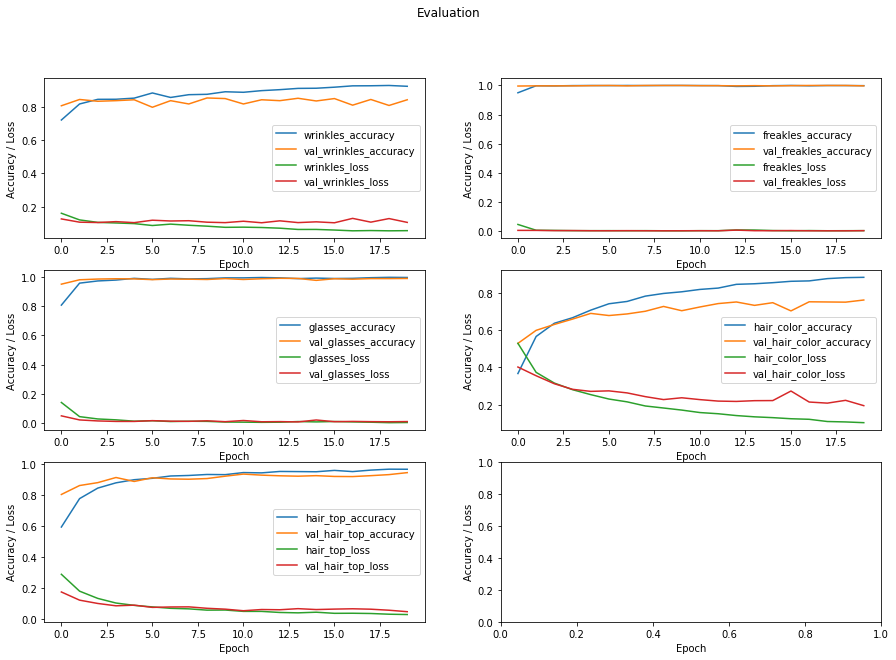

In [ ]:
fig, axs = plt.subplots(3, 2,figsize=(15,10))#, sharex= True,sharey=True)
fig.suptitle('Evaluation')
axs[0, 0].plot(history_wr.history['accuracy'], label='wrinkles_accuracy')
axs[0, 0].plot(history_wr.history['val_accuracy'], label = 'val_wrinkles_accuracy')
axs[0, 0].plot(history_wr.history['loss'], label='wrinkles_loss')
axs[0, 0].plot(history_wr.history['val_loss'], label = 'val_wrinkles_loss')
axs[0, 0].legend(loc='best')
axs[0, 1].plot(history_fr.history['accuracy'], label='freakles_accuracy')
axs[0, 1].plot(history_fr.history['val_accuracy'], label = 'val_freakles_accuracy')
axs[0, 1].plot(history_fr.history['loss'], label='freakles_loss')
axs[0, 1].plot(history_fr.history['val_loss'], label = 'val_freakles_loss')
axs[0, 1].legend(loc='best')
axs[1, 0].plot(history_gl.history['accuracy'], label='glasses_accuracy')
axs[1, 0].plot(history_gl.history['val_accuracy'], label = 'val_glasses_accuracy')
axs[1, 0].plot(history_gl.history['loss'], label='glasses_loss')
axs[1, 0].plot(history_gl.history['val_loss'], label = 'val_glasses_loss')
axs[1, 0].legend(loc='best')
axs[1, 1].plot(history_hc.history['accuracy'], label='hair_color_accuracy')
axs[1, 1].plot(history_hc.history['val_accuracy'], label = 'val_hair_color_accuracy')
axs[1, 1].plot(history_hc.history['loss'], label='hair_color_loss')
axs[1, 1].plot(history_hc.history['val_loss'], label = 'val_hair_color_loss')
axs[1, 1].legend(loc='best')
axs[2, 0].plot(history_ht.history['accuracy'], label='hair_top_accuracy')
axs[2, 0].plot(history_ht.history['val_accuracy'], label = 'val_hair_top_accuracy')
axs[2, 0].plot(history_ht.history['loss'], label='hair_top_loss')
axs[2, 0].plot(history_ht.history['val_loss'], label = 'val_hair_top_loss')
axs[2, 0].legend(loc='best')

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Accuracy / Loss', )
    


In [ ]:
_, train_acc = model_wr.evaluate(X_train_wr, y_train_wr, verbose=0)
_, test_acc = model_wr.evaluate(X_test_wr, y_test_wr, verbose=0)
print('Evaluation for Wrinkles \n Train: %.3f, Validation: %.3f' % (train_acc, test_acc))


Evaluation for Wrinkles 
 Train: 0.954, Validation: 0.841


In [ ]:
_, train_acc = model_fr.evaluate(X_train_fr, y_train_fr, verbose=0)
_, test_acc = model_fr.evaluate(X_test_fr, y_test_fr, verbose=0)
print('Evaluation for Freakles \n Train: %.3f, Validation: %.3f' % (train_acc, test_acc))

Evaluation for Freakles 
 Train: 0.999, Validation: 0.997


In [ ]:
_, train_acc = model_gl.evaluate(X_train_gl, y_train_gl, verbose=0)
_, test_acc = model_gl.evaluate(X_test_gl, y_test_gl, verbose=0)
print('Evaluation for Glasses \n Train: %.3f, Validation: %.3f' % (train_acc, test_acc))

Evaluation for Glasses 
 Train: 0.999, Validation: 0.989


In [ ]:
_, train_acc = model_hc.evaluate(X_train_hc, y_train_hc, verbose=0)
_, test_acc = model_hc.evaluate(X_test_hc, y_test_hc, verbose=0)
print('Evaluation for Hair Color \n Train: %.3f, Validation: %.3f' % (train_acc, test_acc))

Evaluation for Hair Color 
 Train: 0.939, Validation: 0.760


In [ ]:
_, train_acc = model_ht.evaluate(X_train_ht, y_train_ht, verbose=0)
_, test_acc = model_ht.evaluate(X_test_ht, y_test_ht, verbose=0)
print('Evaluation for Hair Top \n Train: %.3f, Validation: %.3f' % (train_acc, test_acc))

Evaluation for Hair Top 
 Train: 0.990, Validation: 0.947


In [ ]:
model_path = "/content/model/"
if os.path.exists(model_path):
  shutil.rmtree(model_path)
  Path(model_path).mkdir()
else:
  Path(model_path).mkdir()

model_wr.save(model_path + "model_wrinkles")
model_fr.save(model_path + "model_freakles")
model_gl.save(model_path + "model_glasses")
model_hc.save(model_path + "model_hair_color")
model_ht.save(model_path + "model_hair_top")

model_wr.save_weights(model_path + "model_weights_wrinkles")
model_fr.save_weights(model_path + "model_weights_freakles")
model_gl.save_weights(model_path + "model_weights_glasses")
model_hc.save_weights(model_path + "model_weights_hair_color")
model_ht.save_weights(model_path + "model_weights_hair_top")


INFO:tensorflow:Assets written to: /content/model/model_wrinkles/assets
INFO:tensorflow:Assets written to: /content/model/model_freakles/assets
INFO:tensorflow:Assets written to: /content/model/model_glasses/assets
INFO:tensorflow:Assets written to: /content/model/model_hair_color/assets
INFO:tensorflow:Assets written to: /content/model/model_hair_top/assets
